# <a name="H2B"></a> Analysing Michael Olma data set with the H2b fluorescent marker

* <a href="#H2B"> Analysing Michael Olma data set with the H2b fluorescent marker </a>
    * <a href="#StateClassifier"> Predicting the state of the cell based on the H2B fluorescent marker</a>
        * <a href="#Unnormalized"> Unnormalized H2b data set</a>
        * <a href="#Normalized">Normalized</a>
        * <a href="#Results1"> Results</a>
    * <a href="#MitoseOrNot">Preclassifier: Mitosis or not</a>
    * <a href="#Fusion"> Fusionning the preclassifier and the 3 state predictor </a>
    * <a href="#HMM"> Hidden Markov Model </a>
    * <a href="#AccuracyResults"> Results of classification </a>
    * <a href="#Final"> Time analysis of cell cycle phases </a>


# <a name="StateClassifier"></a> Predicting the state of the cell based on the H2B fluorescent marker

In [1]:
### All the packages we need:
%matplotlib inline
%load_ext rpy2.ipython

from Reader import Reader
from Randomforest import RandomForest_Autotunner,plot_matrix,Measure,check_rotate
from Traj_creator import Traj_data

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path
import cPickle as pkl


# <a name="Unnormalized"></a> Unnormalized H2b data set

In [2]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data.csv"):
    print "The file existed so I loaded it."
    H2b = Traj_data(file_name="H2b_data.csv")#,pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b=Traj_data() 

    H2b.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)

    H2b.Add_traj(normalize=False)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b.data.to_csv('H2b_data.csv',index=False,header=True)    

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


/home/naylor/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:3006: DtypeWarning: Columns (245) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [3]:
print "The training set has %d instances and %d features"%H2b.train.shape
print "The training set has only %d charateristic features out of %d"%(len(H2b.names),H2b.train.shape[1])

_rand_index_train=(random.sample(H2b.train.index,5))
_rand_col  = random.sample(H2b.names,5)
H2b.train.ix[_rand_index_train,_rand_col]

The training set has 1273 instances and 246 features
The training set has only 239 charateristic features out of 246


,h2_CON,h2_IDM,h8_2SAV,h8_2average,h8_2DAV
6007,0.000000,1.000000,35.921255,15.103612,5.714032
25302,0.039237,0.980381,29.254529,11.186594,6.881341
18684,0.000000,1.000000,34.467377,14.199734,6.067909
23507,0.016606,0.991697,27.651123,10.891192,5.868739
5273,0.000000,1.000000,28.864460,11.416615,6.031230


In [4]:
info_col=[num_str+"_id_frame",num_str+"_id_object",num_str+"_line_id",num_str+"_pos_x",num_str+"_pos_y","traj","Type"]
H2b.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
6007,74,3,6007,124,84,NaN,2
25302,240,154,25302,465,989,NaN,1
18684,189,117,18684,1251,837,7,S
23507,227,148,23507,219,1012,46,S
5273,66,8,5273,1368,180,NaN,2


Processing time: 111.366005 in sec
training dataset: 

S    546
1    378
2    236
M    113
Name: Type, dtype: int64
We now have a classifier with n=320, with an expected accuracy of 0.705 



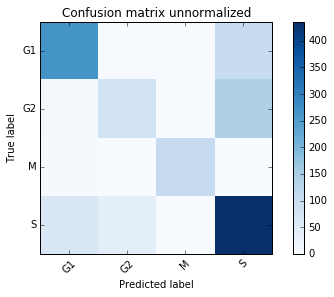

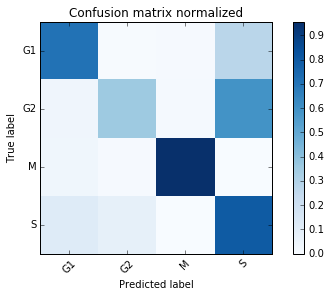

In [5]:
if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model=RandomForest_Autotunner(values)

model.tunning(H2b.train[H2b.names],H2b.train["Type"],3,plot=True,fit_new_model=True)
print "training dataset: \n"
print H2b.train["Type"].value_counts()

i_=np.argmax(model.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f \n" %(n_tree,max(model.MSE))

plot_matrix(model.cm,title="Confusion matrix unnormalized")
plt.show()
model.cm_normalized = model.cm.astype('float') / model.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model.cm_normalized,title="Confusion matrix normalized")
plt.show()

In [6]:
index_no_missing=H2b.data[H2b.names].dropna(axis=0, how='any').index
H2b.data.ix[index_no_missing,"Classif_1"]=model.predict(H2b.data.ix[index_no_missing,H2b.names])
H2b.update()
print "Frequency of predicted values: \n"
print H2b.data["Classif_1"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b.data.shape[0]-len(index_no_missing))

Updated member Group_of_traj
Frequency of predicted values: 

1    33928
S    31220
2     8351
M     5182
Name: Classif_1, dtype: int64

 We were however not able to predict 7 instances because of missing values


In [7]:
temp_X= H2b.data[pd.notnull(H2b.data["traj"])]["Classif_1"]

print "Frequency within trajectories: \n"
print temp_X.value_counts()

print "\n We were however not able to predict %d instances because of missing values" % (sum(pd.isnull(temp_X)))

Frequency within trajectories: 

S    13524
1    12417
2     2502
M     1371
Name: Classif_1, dtype: int64

 We were however not able to predict 0 instances because of missing values


# <a name="Normalized"></a> Normalized data set

Here we are going to try a normalization with respect to the first vector of features after mitosis. 
So if we are traking a certain cell after mitosis, lets call $(X_t)_{t\in \textbf{N}}$ the series of features of this trajectory. The normalization proccess is the following: the trajectory will have new features $(v_t)_{t\in \textbf{N}}$ where $v_t=\frac{X_t}{X_0}$.

This creates a certain number of problems:
- Reduction of training set, we can only use the labels that coincide with cell belonging to a trajectory that has originated from a mitosis.
- The issue above also creates a biais that is that only consider cells after mitosis.
- Sometimes, vector $X_0$ has many 0 and to stop "0/0" we added "+1" to certain features in order to still comapre the evolution with respect to the initial frame. (member $\texttt{.add_error()}$ )



In [8]:
num_str="0015" 
## Well name
if os.path.isfile("H2b_data_norm_mult.csv"):
    print "The file existed so I loaded it."
    H2b_n_m = Traj_data(file_name="H2b_data_norm_mult.csv")#,pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

else:    
    H2b_n_m=Traj_data(pkl_traj_file="/home/pubuntu/Documents/InternWork2/Pkl_file") 

    H2b_n_m.extracting(num_str,"both_channels_0015.hdf5",'primary') 
    ## Extracting the hdf5 file for the primary channel (H2b)
    
    H2b_n_m.add_error() ## We had it so that the data won't have to do 0/0
    H2b_n_m.Add_traj(normalize=True)## ,num_traj=10) ## (you can reduce the number of traj)
    ## Adding Alice's work on tracking to have trajectories

    file_loc="0015_PCNA.xml"

    H2b_n_m.label_finder(file_loc) 
    ## Finding associated labels by minimizing distance by click and distance of cell

    H2b_n_m.renaming_and_merge() 
    ## renaming the labels to have G1=="1", S=="S", G2=="2" and M=="M" 
    #This procedure may take a long time.
    
    H2b_n_m.data.to_csv('H2b_data_norm_mult.csv',index=False,header=True) 

The file existed so I loaded it.
Traj_data built
Reader constructed
Updated member Group_of_traj


In [9]:
H2b_n_m.train.ix[_rand_index_train,_rand_col]

,h2_CON,h2_IDM,h8_2SAV,h8_2average,h8_2DAV
6007,0.000000,1.000000,35.921255,15.103612,5.714032
25302,0.039237,0.980381,29.254529,11.186594,6.881341
18684,0.000000,1.684015,1.499158,2.518948,0.517880
23507,0.008422,1.934664,1.276081,2.050260,0.531368
5273,0.000000,1.000000,28.864460,11.416615,6.031230


In [10]:
H2b_n_m.train.ix[_rand_index_train,info_col]

,0015_id_frame,0015_id_object,0015_line_id,0015_pos_x,0015_pos_y,traj,Type
6007,74,3,6007,124,84,NaN,2
25302,240,154,25302,465,989,NaN,1
18684,189,117,18684,1251,837,7,S
23507,227,148,23507,219,1012,46,S
5273,66,8,5273,1368,180,NaN,2


If we look at the features of a certain trajectory

In [11]:
traj=0
H2b_n_m.data.ix[H2b_n_m.data["traj"]==traj,_rand_col+[num_str+"_id_frame"]].head()

,h2_CON,h2_IDM,h8_2SAV,h8_2average,h8_2DAV,0015_id_frame
400,1.000000,1.000000,1.000000,1.000000,1.000000,5
473,0.184785,1.561849,1.602944,1.827430,1.264082,6
546,0.151947,1.627714,1.639571,1.942666,1.182048,7
620,0.112525,1.710227,1.619063,1.922576,1.160908,8
694,0.024324,1.894835,1.655840,2.096721,0.990327,9
771,0.006081,1.933018,1.824625,2.385251,0.978358,10
844,0.008276,1.928425,1.661839,2.117624,0.973830,11
920,0.000000,1.945746,1.686196,2.134858,1.008937,12
993,0.002516,1.940480,1.558707,2.069054,0.788336,13
1071,0.000000,1.945746,1.933032,2.554827,0.994429,14


# <a name="Results1"> </a> Results


We now have to be careful, not all the training points are part of a trajectory. So we can't compare (with all fairness) the results exposed above with the normalised version.

Updated member Group_of_traj
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
Processing time: 51.315058 in sec


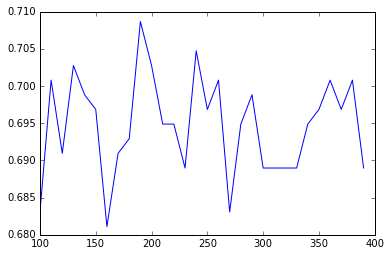

We now have a classifier with n=190, with an expected accuracy of 0.709 for the unnormalized data. 



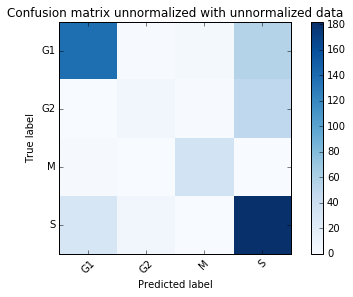

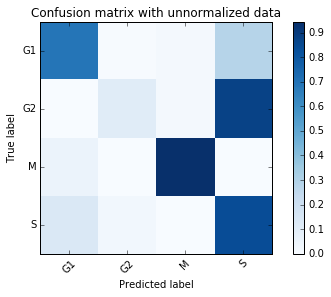

Processing time: 53.042481 in sec


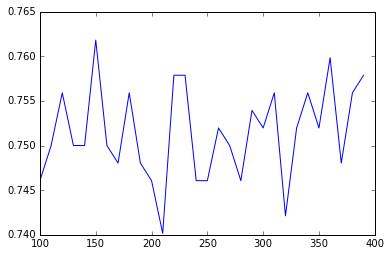

We now have a classifier with n=150, with an expected accuracy of 0.762 for the normalized data. 



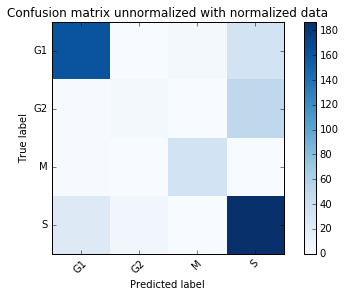

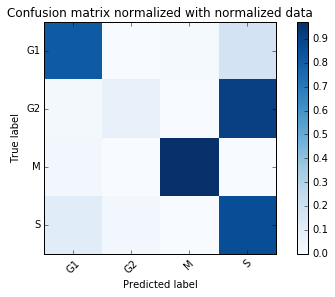

In [12]:

kfold=3

instances_to_keep=pd.notnull(H2b_n_m.data.traj)

H2b.data=H2b.data.ix[instances_to_keep,H2b.data.columns]
H2b.update()

H2b_n_m.data=H2b_n_m.data.ix[instances_to_keep,H2b_n_m.data.columns]
H2b_n_m.update()

print "training dataset: \n"
print H2b_n_m.train["Type"].value_counts()

if H2b.Var_missing[0] in H2b.train.columns:
    H2b.missing_features_train()
if H2b.Var_missing[0] in H2b.data.columns:
    H2b.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_t=RandomForest_Autotunner(values)

model_t.tunning(H2b.train[H2b.names],H2b.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_t.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the unnormalized data. \n" %(n_tree,max(model_t.MSE))

plot_matrix(model_t.cm,title="Confusion matrix unnormalized with unnormalized data")
plt.show()
model_t.cm_normalized = model_t.cm.astype('float') / model_t.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_t.cm_normalized,title="Confusion matrix with unnormalized data")
plt.show()



if H2b_n_m.Var_missing[0] in H2b_n_m.train.columns:
    H2b_n_m.missing_features_train()
if H2b_n_m.Var_missing[0] in H2b_n_m.data.columns:
    H2b_n_m.missing_features_data()
values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train[H2b_n_m.names],H2b_n_m.train["Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))


plot_matrix(model_n_m.cm,title="Confusion matrix unnormalized with normalized data")
plt.show()
model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Confusion matrix normalized with normalized data")
plt.show()

We conclude that this normalization is a need as it improves considerably the accuracy. However our predictions of G2 are still very poor. One may wonder if the unnormalized data does possess a certain for G2, as his predictions for G2 were bad but that this bad.

# <a name="MitoseOrNot"></a> Preclassifier for Mitosis or Not

As explained in the abstract of "Normalized data set" we had to considerably reduce the amount of labelled data. We only have 37 labelled instances for Mitosis, this is too scares so we decide to add an extra classification layer in order to only detect Mitosis events. It is know that we are going to good results as the H2B marker is meant to be very informative of Mitosis events.

In [13]:
train_file="MitoseClassif.arff"

train_1=Reader()
train_1.arrf_read(train_file)
train_1.renaming_for_mitosis()

train_1.data["label"].value_counts()

Reader constructed


O    2842
S    1293
M    1016
Name: label, dtype: int64

Processing time: 518.159643 in sec


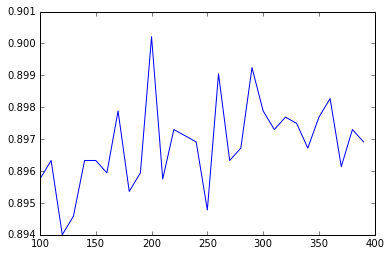

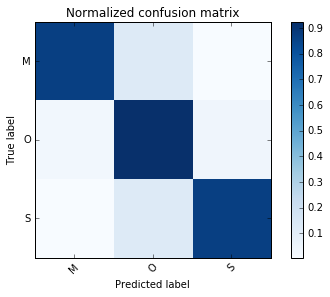

In [14]:
kfold=3

if train_1.Var_missing[0] in train_1.data.columns:
    train_1.missing_features_data()
    
values=[100 + i*10 for i in range(30)]
model_1=RandomForest_Autotunner(values)

model_1.tunning(train_1.data[train_1.names],train_1.data["label"],kfold,plot=True,fit_new_model=True)
plt.show()

model_1.cm_normalized = model_1.cm.astype('float') / model_1.cm.sum(axis=1)[:, np.newaxis]

plot_matrix(model_1.cm_normalized,title="Normalized confusion matrix",names=["M","O","S"])
plt.show()

As expected we reach a very high value of accuracy for detecting Mitosis events.

# <a name="Fusion"></a> Fusionning the preclassifier and the 3 state predictor

Because we have too few instances in phase M, we used the first classifier. This classifier has priority over the first prediction as it the H2B marker is meant to be informative about the Mitosis events.

Updated member Group_of_traj
Updated member Group_of_traj
Frequency of predicted values for the Mitosis or not classifier: 

O    14566
S    14352
M      896
Name: MitoseOrNot, dtype: int64

 We were however not able to predict 0 instances because of missing values
Updated member Group_of_traj
training dataset: 

S    217
1    199
2     56
Name: Type, dtype: int64
Processing time: 48.382503 in sec


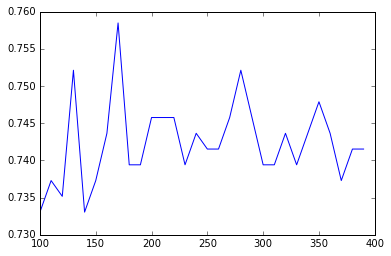

We now have a classifier with n=170, with an expected accuracy of 0.758 for the normalized data. 



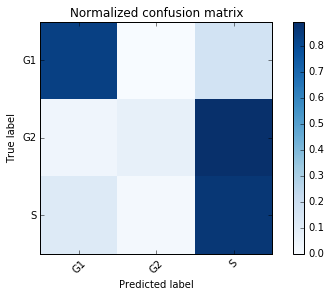

Frequency of predicted values for the 3 state classifier: 

1    15974
S    12475
2     1365
Name: 3State, dtype: int64


In [15]:
## To reduce computation and none useless things, we remove instances that do not belong to trajectories.

index_traj=pd.notnull(H2b_n_m.data["traj"])
H2b_n_m.data=H2b_n_m.data.ix[index_traj,H2b_n_m.data.columns]
H2b.data=H2b.data.ix[index_traj,H2b.data.columns]

H2b_n_m.update()
H2b.update()
## Predicting model 1

index_no_missing=H2b_n_m.data[H2b_n_m.names].dropna(axis=0, how='any').index
H2b_n_m.data.ix[index_no_missing,"MitoseOrNot"]=model_1.predict(H2b.data.ix[index_no_missing,train_1.names]) 
## Carefull, we put the unnormalized data in the above prediction.

print "Frequency of predicted values for the Mitosis or not classifier: \n"
print H2b_n_m.data["MitoseOrNot"].value_counts()
print "\n We were however not able to predict %d instances because of missing values" % (H2b_n_m.data.shape[0]-len(index_no_missing))

H2b_n_m.data

H2b_n_m.update()

##We have to retrain the model for the normalized version as this one was trained with the class M

index_no_M=H2b_n_m.data["Type"]!="M"

print "training dataset: \n"
print H2b_n_m.train.ix[index_no_M,"Type"].value_counts()


values=[100 + i*10 for i in range(30)]
model_n_m=RandomForest_Autotunner(values)

model_n_m.tunning(H2b_n_m.train.ix[index_no_M,H2b_n_m.names],H2b_n_m.train.ix[index_no_M,"Type"],kfold,plot=True,fit_new_model=True)
plt.show()

i_=np.argmax(model_n_m.MSE)
n_tree=values[i_]
print "We now have a classifier with n=%d, with an expected accuracy of %5.3f for the normalized data. \n" %(n_tree,max(model_n_m.MSE))

model_n_m.cm_normalized = model_n_m.cm.astype('float') / model_n_m.cm.sum(axis=1)[:, np.newaxis]
plot_matrix(model_n_m.cm_normalized,title="Normalized confusion matrix",names=["G1","G2","S"])
plt.show()

H2b_n_m.data.ix[index_no_missing,"3State"]=model_n_m.predict(H2b_n_m.data.ix[index_no_missing,H2b_n_m.names])
print "Frequency of predicted values for the 3 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"3State"].value_counts()




In [16]:
### Giving priority to the first classif...
def f(value_1,value_2):
    if value_1=="M":
        return(value_1)
    else:
        return(value_2)
H2b_n_m.data["Pred_Fusion"]=H2b_n_m.data.apply(lambda r: f(r["MitoseOrNot"],r["3State"]),axis=1)

print "Frequency of predicted values for the 4 state classifier: \n"
print H2b_n_m.data.ix[index_no_missing,"Pred_Fusion"].value_counts()
H2b_n_m.update()

Frequency of predicted values for the 4 state classifier: 

1    15082
S    12472
2     1364
M      896
Name: Pred_Fusion, dtype: int64
Updated member Group_of_traj


Our first classifiers are ready and are stored as "Pred_Fusion". We now to have apply the hidden markov model as we did when the fluroescent marker was the PCNA.

# <a name="HMM"></a> Hidden Markov Model

We are now going to tune the hidden markov model and then correct the trajectories.

In [17]:
##First we are going to seperate beginning M's and ending M's
for i in range(len(H2b_n_m.trajectories)):
    new_obs=np.array(H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"])
    n_obs=len(new_obs)
    for j in range(n_obs/2):
        if new_obs[j]=='M':
            new_obs[j]='B'  #Beginning
    H2b_n_m.data.ix[H2b_n_m.data["traj"]==i,"Pred_Fusion"]=new_obs
H2b_n_m.data.ix[H2b_n_m.data["Pred_Fusion"]=='M',"Pred_Fusion"]='E' #Ending


* What should we put as a emission state probability matrix? This question is complicated as we are mixting the confusion matrixes of two classifications task. But with a little bit of handy work, we satisfied ourselfs with the following state emission probability matrix

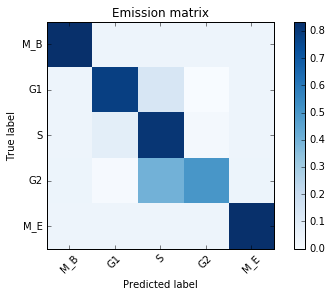

In [18]:
X3=model_n_m.cm_normalized
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T
X3=np.array([X3[0],X3[2],X3[1]])
X3=X3.T

EmissionMat=np.zeros(shape=(5,5))
EmissionMat[0,0]=model_1.cm_normalized[0,0]
EmissionMat[4,4]=model_1.cm_normalized[0,0]
EmissionMat[1:5,0]=(1-model_1.cm_normalized[0,0])/3
EmissionMat[0:4,4]=(1-model_1.cm_normalized[0,0])/3

### Bricolage

EmissionMat[1:4,1:4]=X3
EmissionMat[1:4,1:3]+=-EmissionMat[3,0]*2/3

### On modifie car la diag n'est pas assez bonne...
EmissionMat[3,2:4]=[0.4,0.5]

EmissionMat[0,1:4]=sum(model_1.cm_normalized[0,1:3])/3
EmissionMat[4,1:4]=sum(model_1.cm_normalized[0,1:3])/3

EmissionMat=abs(EmissionMat).astype('float') / abs(EmissionMat).sum(axis=1)[:, np.newaxis]
## Put something better then abs... 

plot_matrix(EmissionMat,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()

H2b_n_m.data=H2b_n_m.data.sort_values(['traj', num_str+"_id_frame"], ascending=[1, 1])

data=H2b_n_m.data.ix[pd.notnull(H2b_n_m.data["traj"]),["traj","Pred_Fusion"]]


data.ix[data.Pred_Fusion=='2',"Pred_Fusion"]="4"
data.ix[data.Pred_Fusion=='1',"Pred_Fusion"]="2"
data.ix[data.Pred_Fusion=='B',"Pred_Fusion"]="1"
data.ix[data.Pred_Fusion=='E',"Pred_Fusion"]="5"
data.ix[data.Pred_Fusion=='S',"Pred_Fusion"]="3"

%Rpush EmissionMat
%Rpush data 

In [19]:
%%R 
obs_number=0
print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

library(HMM)
trans=list()  #List of outputs
emi=list()    

emission_matrix=EmissionMat
transition_prior=t(matrix(c(  .7  , .27 , .01 , .01 , .01
                            , .01 , .7  , .27 , .01 , .01
                            , .01 , .01 , .7  , .27 , .01
                            , .01 , .01 , .01 , .7  , .27
                            , .01 , .01 , .01 , .01  , 0.96 ),5)) 

startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transition_prior,
              emissionProbs=emission_matrix
              ,startProbs=startProbs)


n_traj=max(data$traj)
j=1
for (i in 0:(n_traj-1)){
    obs=data[data$traj==i,"Pred_Fusion"]
    if (i==obs_number){
        test=obs
        print(test)
    }
    
    hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
                  startProbs=startProbs,
                  emissionProbs=emission_matrix,
                  transProbs=transition_prior)
    bw=try(baumWelch(hmm,observation=obs,10),silent = TRUE)
    if (!(inherits(bw, "try-error"))){
      trans[[j]]=bw$hmm$transProbs
      emi[[j]]=bw$hmm$emissionProbs
      j=j+1  
    }
}

mean_t=matrix(0,ncol=5,nrow=5)
mean_e=matrix(0,ncol=5,nrow=5)
for (i in 1:length(trans)){
  mean_t=mean_t+trans[[i]]
  mean_e=mean_e+emi[[i]]
}
mean_t=mean_t/length(trans)
mean_e=mean_e/length(trans)

var_t=matrix(0,ncol=5,nrow=5)
var_e=matrix(0,ncol=5,nrow=5)

for (i in 1:length(trans)){
  var_t=var_t+(trans[[i]]-mean_t)*(trans[[i]]-mean_t)
  var_e=var_e+(emi[[i]]-mean_e)*(emi[[i]]-mean_e)
}
var_t=var_t/length(trans)
var_e=var_e/length(trans)

[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 0"
  [1] 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2 3 2 2 2 2 2 3 3 3 3 2 3 3 3 2 2
 [75] 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3 3 3 3 4
[149] 3 3 3 3 3 3 3 3 4 3 3 4 4 3 3 3 3 3 4 3 3 4 3 4 3 3 3 4 4 4 4 3 5 5 5 5 5
Levels: 1 2 3 4 5


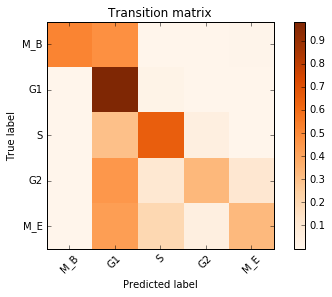

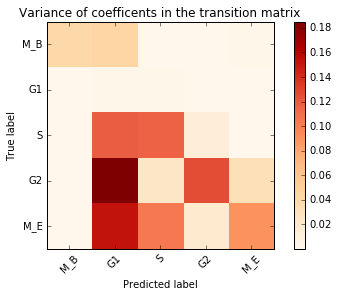

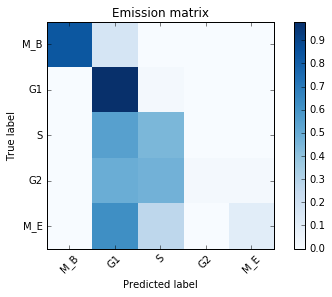

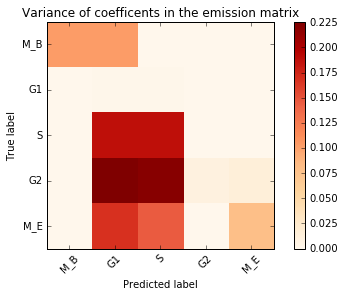

In [20]:
%Rpull mean_t mean_e var_t var_e
plot_matrix(mean_t,title="Transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.Oranges)
plt.show()
plot_matrix(var_t,title="Variance of coefficents in the transition matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()
plot_matrix(mean_e,title="Emission matrix",names=["M_B","G1","S","G2","M_E"])
plt.show()
plot_matrix(var_e,title="Variance of coefficents in the emission matrix",names=["M_B","G1","S","G2","M_E"],cmap=plt.cm.OrRd)
plt.show()

In [21]:
%%R 
obs_number=2

ligne1=mean_t[1,1]+mean_t[1,2]
ligne2=mean_t[2,2]+mean_t[2,3]
ligne3=mean_t[3,3]+mean_t[3,4]
ligne4=mean_t[4,4]+mean_t[4,5]

transProbs=t(matrix(c(mean_t[1,1]/ligne1  , mean_t[1,2]/ligne1    ,0                 , 0                 ,0
                      , 0                 , mean_t[2,2]/ligne2    ,mean_t[2,3]/ligne2, 0                 ,0
                      , 0                 , 0                     ,mean_t[3,3]/ligne3, mean_t[3,4]/ligne3,0
                      , 0                 , 0                     ,0                 , mean_t[4,4]/ligne4,mean_t[4,5]/ligne4
                      , 0                 , 0                     ,0                 , 0                 ,1 ),5))
startProbs=c(0.3, 0.7, 0.0, 0.0, 0.0)

hmm = initHMM(c("1","2","3","4","5"),c("1","2","3","4","5"),
              transProbs=transProbs,
              emissionProbs=emission_matrix  ##We still keep the confusion matrix of the first classification
              ,startProbs=startProbs)

print(paste("To assess briefly what is happening, we printed a sequence of observation, sequence number:",toString(obs_number) ))

for (i in 0:(n_traj-1)){
  obs=data[data$traj==i,"Pred_Fusion"]
  new_obs=as.integer(viterbi(hmm,observation=obs))
  data[data$traj==i,"HMM"]=new_obs
  if (i==obs_number){
      print(obs)
      print(new_obs)
  }
}


[1] "To assess briefly what is happening, we printed a sequence of observation, sequence number: 2"
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 2 3
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 3 4 3 3 3 4 4 4 3 3 3 4
[186] 4 4 4 5 5 2 2
Levels: 1 2 3 4 5
  [1] 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [38] 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 [75] 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[112] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
[149] 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4
[186] 4 4 4 5 5 5 5


In [ ]:
## If needed...
##H2b_n_m.data=H2b_n_m.data.drop("HMM",axis=1)

In [22]:
%Rpull data

data.ix[data.HMM==1,"HMM"]="M"
data.ix[data.HMM==2,"HMM"]="1"
data.ix[data.HMM==3,"HMM"]="S"
data.ix[data.HMM==4,"HMM"]="2"
data.ix[data.HMM==5,"HMM"]="M"
to_join=pd.Series(data["HMM"])
to_join.index=[int(el) for el in to_join.index]

H2b_n_m.data=H2b_n_m.data.join(to_join)
H2b_n_m.update()


print H2b_n_m.train["traj","Type","MitoseOrNot","3State","Pred_Fusion","HMM"].head()


obs_number=2
i=0
G1=[]
S=[]
G2=[]
CC=[]
print "To quickly asses we print the trajectory and his corrected trajectory, for sequence number:" + str(obs_number)
for el in H2b_n_m.Group_of_traj:
    new_obs=el[1]["HMM"]
    if i==obs_number:
        test=np.array(el[1]["Pred_Fusion"])
        test_hmm=np.array(el[1]["HMM"])
        print "Pred_Fusion: \n"
        print test
        print "\n Corrected HMM: \n"
        print test_hmm
    i+=1
    if not check_rotate(new_obs):
        G1.append(Measure(new_obs,'1',_last=True))
        S.append(Measure(new_obs,'S',_last=True,_first=True))
        G2.append(Measure(new_obs,'2',_first=True))
        CC.append(Measure(new_obs,'M'))
    elif not check_rotate(new_obs[:-1]):
        G1.append(Measure(new_obs[:-1],'1',_last=True))
        S.append(Measure(new_obs[:-1],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-1],'2',_first=True))
        CC.append(Measure(new_obs[:-1],'M'))
    elif not check_rotate(new_obs[:-2]):
        G1.append(Measure(new_obs[:-2],'1',_last=True))
        S.append(Measure(new_obs[:-2],'S',_last=True,_first=True))
        G2.append(Measure(new_obs[:-2],'2',_first=True))
        CC.append(Measure(new_obs[:-2],'M'))
    else:
        G1.append(-1)
        S.append(-1)
        G2.append(-1)
        CC.append(-1)
        
from numpy import mean,std
ratio=5.9/60
G1_p=[el*ratio for el in G1 if el>-1]
S_p= [el*ratio for el in S  if el>-1]
G2_p=[el*ratio for el in G2 if el>-1]
CC_p=[el*ratio for el in CC if el>-1] 
res = {'mean' : pd.Series([mean(G1_p), mean(S_p), mean(G2_p),mean(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Standard deviation' : pd.Series([std(G1_p),std(S_p),std(G2_p),std(CC_p)], index=['G1', 'S', 'G2','CellCycle']),
'Accepted trajectories': pd.Series([len(G1_p),len(S_p),len(G2_p),len(CC_p)], index=['G1', 'S', 'G2','CellCycle'])
      }

Updated member Group_of_traj
       traj Type MitoseOrNot 3State Pred_Fusion  HMM
6007    NaN  NaN         NaN    NaN         NaN  NaN
25302   NaN  NaN         NaN    NaN         NaN  NaN
18684     7    S           S      S           S    S
23507    46    S           S      S           S    S
5273    NaN  NaN         NaN    NaN         NaN  NaN
To quickly asses we print the trajectory and his corrected trajectory, for sequence number:2
Pred_Fusion: 

['B' 'B' 'B' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1'
 '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '1' 'S' 'S'
 '1' 'S' '1' '1' '1' '1' '1' '1' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S'
 'S' 'S' 'S' 'S' 'S' 'S' 'S' 'S' '

# <a name="AccuracyResults"></a> Results of classification

We will first assess the classification accuracy that we obtain with the 2 classifiers and the correcting model.

S    217
1    199
2     56
M     36
Name: Type, dtype: int64
We reach an accuracy of 0.892 



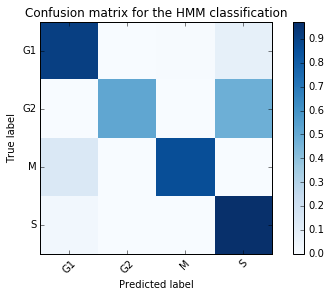

In [23]:
from sklearn.metrics import confusion_matrix

temp_X=H2b_n_m.train.ix[pd.notnull(H2b_n_m.train["HMM"]),["HMM","Type"]]
print temp_X["Type"].value_counts()
cm=confusion_matrix(temp_X.Type,temp_X.HMM)

print "We reach an accuracy of %5.3f \n" %(float(cm.trace())/cm.sum())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_matrix(cm_normalized,title="Confusion matrix for the HMM classification")

This is a very promising result asMost of the errors are made between S and G2, if we regroup them we achieve these results.

T    273
1    199
M     36
Name: Type, dtype: int64
We reach an accuracy of 0.945 



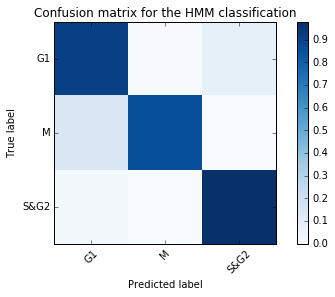

In [24]:
temp_X=H2b_n_m.train.ix[pd.notnull(H2b_n_m.train["HMM"]),["HMM","Type"]]

temp_X.ix[temp_X.Type=="S","Type"]="T" #Together
temp_X.ix[temp_X.HMM=="S","HMM"]="T"
temp_X.ix[temp_X.Type=="2","Type"]="T"
temp_X.ix[temp_X.HMM=="2","HMM"]="T"


print temp_X["Type"].value_counts()


cm=confusion_matrix(temp_X.Type,temp_X.HMM)

print "We reach an accuracy of %5.3f \n" %(float(cm.trace())/cm.sum())

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plot_matrix(cm_normalized,title="Confusion matrix for the HMM classification",names=["G1","M","S&G2"])

Our classifier seems to seperate correctly phases G1 and S.

# <a name="Final"></a> Time analysis of cell cycle phases


In [25]:
print "With only M: \n"
pd.DataFrame(res)

With only M: 



,Accepted trajectories,Standard deviation,mean
G1,164,3.603361,6.927104
S,102,3.117631,8.305310
G2,102,2.182703,1.770000
CellCycle,102,2.053659,17.131209


The time for G1 is the same as the time extracted from the PCNA fluorescent marker. This confirms that we feel that we can seperate G1 and S.